# Topic modeling

## Comparación entre Propuesta de Constitución y Constitución Vigente

### Librerías

In [1]:
import pandas as pd
import numpy as np

In [2]:
# for text preprocessing
import re
import spacy

from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

# import vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [3]:
# import LDA from sklearn
from sklearn.decomposition import LatentDirichletAllocation

In [4]:
import networkx as nx

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import text
import seaborn as sns

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
esp_stop = stopwords.words('spanish')
esp_stop = esp_stop + ['ser','tener','deber']

## Funciones

In [8]:
def delete_stopwords(text):
    """
    Función para eliminar stopwords del texto
    """
    doc = nlp(text)
    return ' '.join([word.text for word in doc if word.text not in esp_stop])

In [9]:
def cleaner(df, text):
    """
    Función para dejar las palabras en minúscula, eliminar números, puntuación, espacios y saltos de línea.
    """
    df[text] = df[text].str.lower()
    df[text] = df[text].apply(lambda x: re.sub("[0-9]", '', str(x)))
    df[text] = df[text].str.translate(str.maketrans(' ', ' ', string.punctuation))
    df[text] = df[text].str.replace('\n',' ')
    df[text] = df[text].str.replace('nº','')
    df[text] = df[text].str.replace('n°','')
    df[text] = df[text].str.replace('n º','')
    df[text] = df[text].str.replace('n °','')
    df[text] = df[text].str.replace('º','')
    df[text] = df[text].str.replace('°','')
    df[text] = df[text].str.strip()
    df[text] = df[text].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')  # Eliminación de acentos
    

In [10]:
def wordcloud(data):
    """
    Función para graficar un wordcloud
    """
    wc = WordCloud(background_color='white',width=800, height=400, max_words=200, colormap = 'plasma').generate_from_frequencies(data)
    plt.figure(figsize=(15, 10))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

### Importando textos ya digitalizados

In [11]:
df_propuesta = pd.read_csv('data/processed/constitucion_propuesta.csv')
df_propuesta.rename(columns = {'articulo':'nro_articulo'}, inplace = True)
df_propuesta['constitucion'] = 'Propuesta'
df_propuesta = df_propuesta[df_propuesta['capitulo']!='Convención Constitucional']

df_vigente = pd.read_csv('data/processed/constitucion_actual.csv')
df_vigente.drop(columns = 'id', inplace = True)
df_vigente['constitucion'] = 'Vigente'

df = pd.concat([df_vigente,df_propuesta])

df = df[['constitucion','capitulo', 'titulo_capitulo', 'nro_articulo', 'texto']]

In [12]:
df.reset_index(drop = True, inplace = True)

In [13]:
df.sample(3)

,constitucion,capitulo,titulo_capitulo,nro_articulo,texto
1615,Propuesta,Capítulo VI,Estado Regional y Organización Territorial,Artículo 164,"- k) Aprobar, rechazar o proponer modificacion..."
1373,Propuesta,Capítulo V,Buen Gobierno y Función Pública,Artículo 164,### Artículo 175
1826,Propuesta,Capítulo VII,Poder Legislativo,Artículo 263,- d) Instituir las normas sobre enajenación d...


### Desarrollo

Basado en: https://github.com/sethns/Latent-Dirichlet-Allocation-LDA-/blob/main/Topic%20Modeling%20_%20Extracting%20Topics_%20Using%20Sklearn.ipynb

Definiendo nlp

In [14]:
nlp = spacy.load('es_core_news_sm')

Limpiando texto

In [15]:
cleaner(df, 'texto')

In [16]:
df['texto_clean'] = df['texto'].apply(lambda x: delete_stopwords(x))

In [17]:
df.sample()

,constitucion,capitulo,titulo_capitulo,nro_articulo,texto,texto_clean
77,Vigente,Capítulo III,DE LOS DERECHOS Y DEBERES CONSTITUCIONALES,Artículo 19,la libertad de conciencia la manifestacion de ...,libertad conciencia manifestacion todas creenc...


In [18]:
cv_vectorizer = CountVectorizer(ngram_range = (1,1))
cv_arr = cv_vectorizer.fit_transform(df['texto_clean'])

In [19]:
cv_arr

<2619x5615 sparse matrix of type '<class 'numpy.int64'>'
	with 41120 stored elements in Compressed Sparse Row format>

In [20]:
# Creating vocabulary array which will represent all the corpus 
vocab_cv = cv_vectorizer.get_feature_names()

# get the vocb list
vocab_cv[:10]

['abandono',
 'abastecer',
 'abastecimiento',
 'abierta',
 'abiertamente',
 'abierto',
 'abiertos',
 'abogada',
 'abogadas',
 'abogado']

### Implementando LDA

In [30]:
# Implementation of LDA:
    
# Create object for the LDA class 
# Inside this class LDA: define the components:
lda_model = LatentDirichletAllocation(n_components = 7, max_iter = 20, random_state = 20)

# fit transform on model on our count_vectorizer : running this will return our topics 
X_topics = lda_model.fit_transform(cv_arr)

# .components_ gives us our topic distribution 
topic_words = lda_model.components_



In [31]:
#  Define the number of Words that we want to print in every topic : n_top_words
n_top_words = 15

for i, topic_dist in enumerate(topic_words):
    
    # np.argsort to sorting an array or a list or the matrix acc to their values
    sorted_topic_dist = np.argsort(topic_dist)
    
    # Next, to view the actual words present in those indexes we can make the use of the vocab created earlier
    topic_words = np.array(vocab_cv)[sorted_topic_dist]
    
    # so using the sorted_topic_indexes we ar extracting the words from the vocabulary
    # obtaining topics + words
    # this topic_words variable contains the Topics  as well as the respective words present in those Topics
    topic_words = topic_words[:-n_top_words:-1]
    print ("Topic", str(i), topic_words)

Topic 0 ['ley' 'constitucion' 'republica' 'atribuciones' 'nacional' 'podra'
 'presidente' 'organizacion' 'funciones' 'funcionamiento' 'demas'
 'justicia' 'vigencia' 'leyes']
Topic 1 ['derecho' 'ley' 'constitucion' 'persona' 'toda' 'podra' 'derechos'
 'ejercicio' 'organos' 'materias' 'asi' 'declaracion' 'aprobacion'
 'seguridad']
Topic 2 ['articulo' 'ley' 'inciso' 'sera' 'tribunal' 'podra' 'leyes' 'perjuicio'
 'constitucion' 'caso' 'tribunales' 'ninguna' 'pena' 'competencia']
Topic 3 ['derechos' 'ley' 'derecho' 'personas' 'ejercicio' 'educacion' 'humanos'
 'constitucion' 'proteccion' 'publica' 'participacion' 'naturaleza'
 'chile' 'garantizar']
Topic 4 ['regional' 'territoriales' 'region' 'constitucion' 'entidades' 'gobierno'
 'autonoma' 'administracion' 'competencias' 'ley' 'desarrollo' 'publicos'
 'participacion' 'creacion']
Topic 5 ['ley' 'constitucional' 'organica' 'fuerza' 'texto' 'decreto' 'electoral'
 'articulo' 'general' 'regionales' 'refundido' 'coordinado' 'ministerio'
 'podra

Creando df de tópicos

In [32]:
df_topicos = pd.DataFrame(X_topics)
df_topicos.columns = ['Topic 0', 'Topic 1', 'Topic 2', 'Topic 3','Topic 4','Topic 5','Topic 6']

Agrando los tópicos al df original

In [33]:
df_con_topicos = pd.merge(df, df_topicos, left_index = True, right_index = True)
df_con_topicos['max_topic'] = X_topics.argmax(axis = 1)

In [34]:
df_con_topicos.to_csv('data/processed/df_con_topicos.csv', index = False, sep = ';')

### Cuanto aparece cada tópico en cada constitución?

In [47]:
temp1 = df_con_topicos[df_con_topicos['constitucion']=='Propuesta'].groupby(['max_topic'])['texto'].count().reset_index()
temp1['peso'] = temp1['texto']/temp1['texto'].sum()
temp1.columns = ['max_topic','texto_propuesta','peso_propuesta']

In [48]:
temp2 = df_con_topicos[df_con_topicos['constitucion']!='Propuesta'].groupby(['max_topic'])['texto'].count().reset_index()
temp2['peso'] = temp2['texto']/temp2['texto'].sum()
temp2.columns = ['max_topic','texto_vigente','peso_vigente']

In [50]:
comparacion = pd.merge(temp1, temp2, on = 'max_topic')

In [52]:
comparacion['peso_propuesta_neg'] = comparacion['peso_propuesta']*-1

In [53]:
comparacion

,max_topic,texto_propuesta,peso_propuesta,texto_vigente,peso_vigente,peso_propuesta_neg
0,0,265,0.149972,142,0.166667,-0.149972
1,1,157,0.088851,63,0.073944,-0.088851
2,2,318,0.179966,93,0.109155,-0.179966
3,3,421,0.238257,115,0.134977,-0.238257
4,4,215,0.121675,55,0.064554,-0.121675
5,5,138,0.078098,140,0.164319,-0.078098
6,6,253,0.143181,244,0.286385,-0.143181


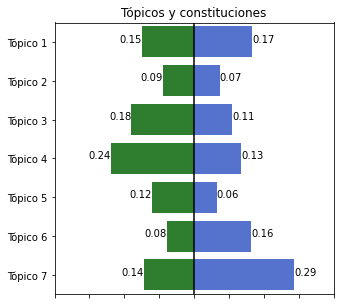

In [106]:
fig, ax = plt.subplots(1,1,figsize = (5,5))

sns.barplot(
    data = comparacion,
    x = 'peso_vigente',
    y = 'max_topic',
    orient = 'h',
    color = 'royalblue',
    ax = ax
)

sns.barplot(
    data = comparacion,
    x = 'peso_propuesta_neg',
    y = 'max_topic',
    orient = 'h',
    color = 'forestgreen',
    ax = ax
)

plt.axvline(x = 0, color = 'black')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels(
    [
        'Tópico 1',
        'Tópico 2',
        'Tópico 3',
        'Tópico 4',
        'Tópico 5',
        'Tópico 6',
        'Tópico 7'
    ]
)

ax.set_xticklabels([])
ax.set_xlim([-0.4,0.4])
ax.set_title('Tópicos y constituciones')

for i, r in comparacion.iterrows():
    ax.annotate(text = round(r['peso_vigente'],2), xy = (r['peso_vigente'],r['max_topic']))
    ax.annotate(text = round(r['peso_propuesta'],2), xy = (r['peso_propuesta_neg'],r['max_topic']), ha = 'right')
